# Seleção da Database
## Database: 
Brazilian E-Commerce Public Database by Olist
https://www.kaggle.com/olistbr/brazilian-ecommerce?select=olist_order_items_dataset.csv

### Descrição: 
A database foi provida pela Olist, uma empresa de marketplace situada no Brasil. A Olist conecta pequenos negócios por todo o Brasil de uma forma simples. Vendedores conseguem vender seus produtos diretamente pela Olist Store, as entregas são feitas por meio de parceiros.

### Problema de Negócio:
Quais são os principais fatores que alavancam o número de vendas? Quais os fatores que impactam na avaliação do cliente?

### Perguntas:
- 1. Como as vendas foram afetadas entre 2016 e 2018?

- 2. Existe diferença significativa de venda para cada um dos seguintes fatores:
    - Ano
    - Mês
    - Dia da Semana
    - Horário
    - Região
    - Método de Pagamento
   
- 3. Quais produtos e categoria possuem maiores vendas?
   
- 4. As notas de review do produto possuem impacto no número de vendas?
    - Realizar plot de nuvem de palavras

- 5. A localização impacta no tempo de entrega?
    - Heatmap por localização (Mapa)

- 6. O tempo de entrega impacta no review do produto?

- 7. Quais categorias são mais consumidas por região?
    - Diferentes regiões possuem maior adesão por diferentes tipos de produto?

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from warnings import simplefilter

In [31]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Herikc Brecher e João Hutner" --iversions

Author: Herikc Brecher e João Hutner

matplotlib: 3.3.4
pandas    : 1.2.4
seaborn   : 0.11.1
numpy     : 1.19.5



In [32]:
simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
sns.set_theme()

In [33]:
seed_ = 194
np.random.seed(seed_)

# Carregamento dos Dados

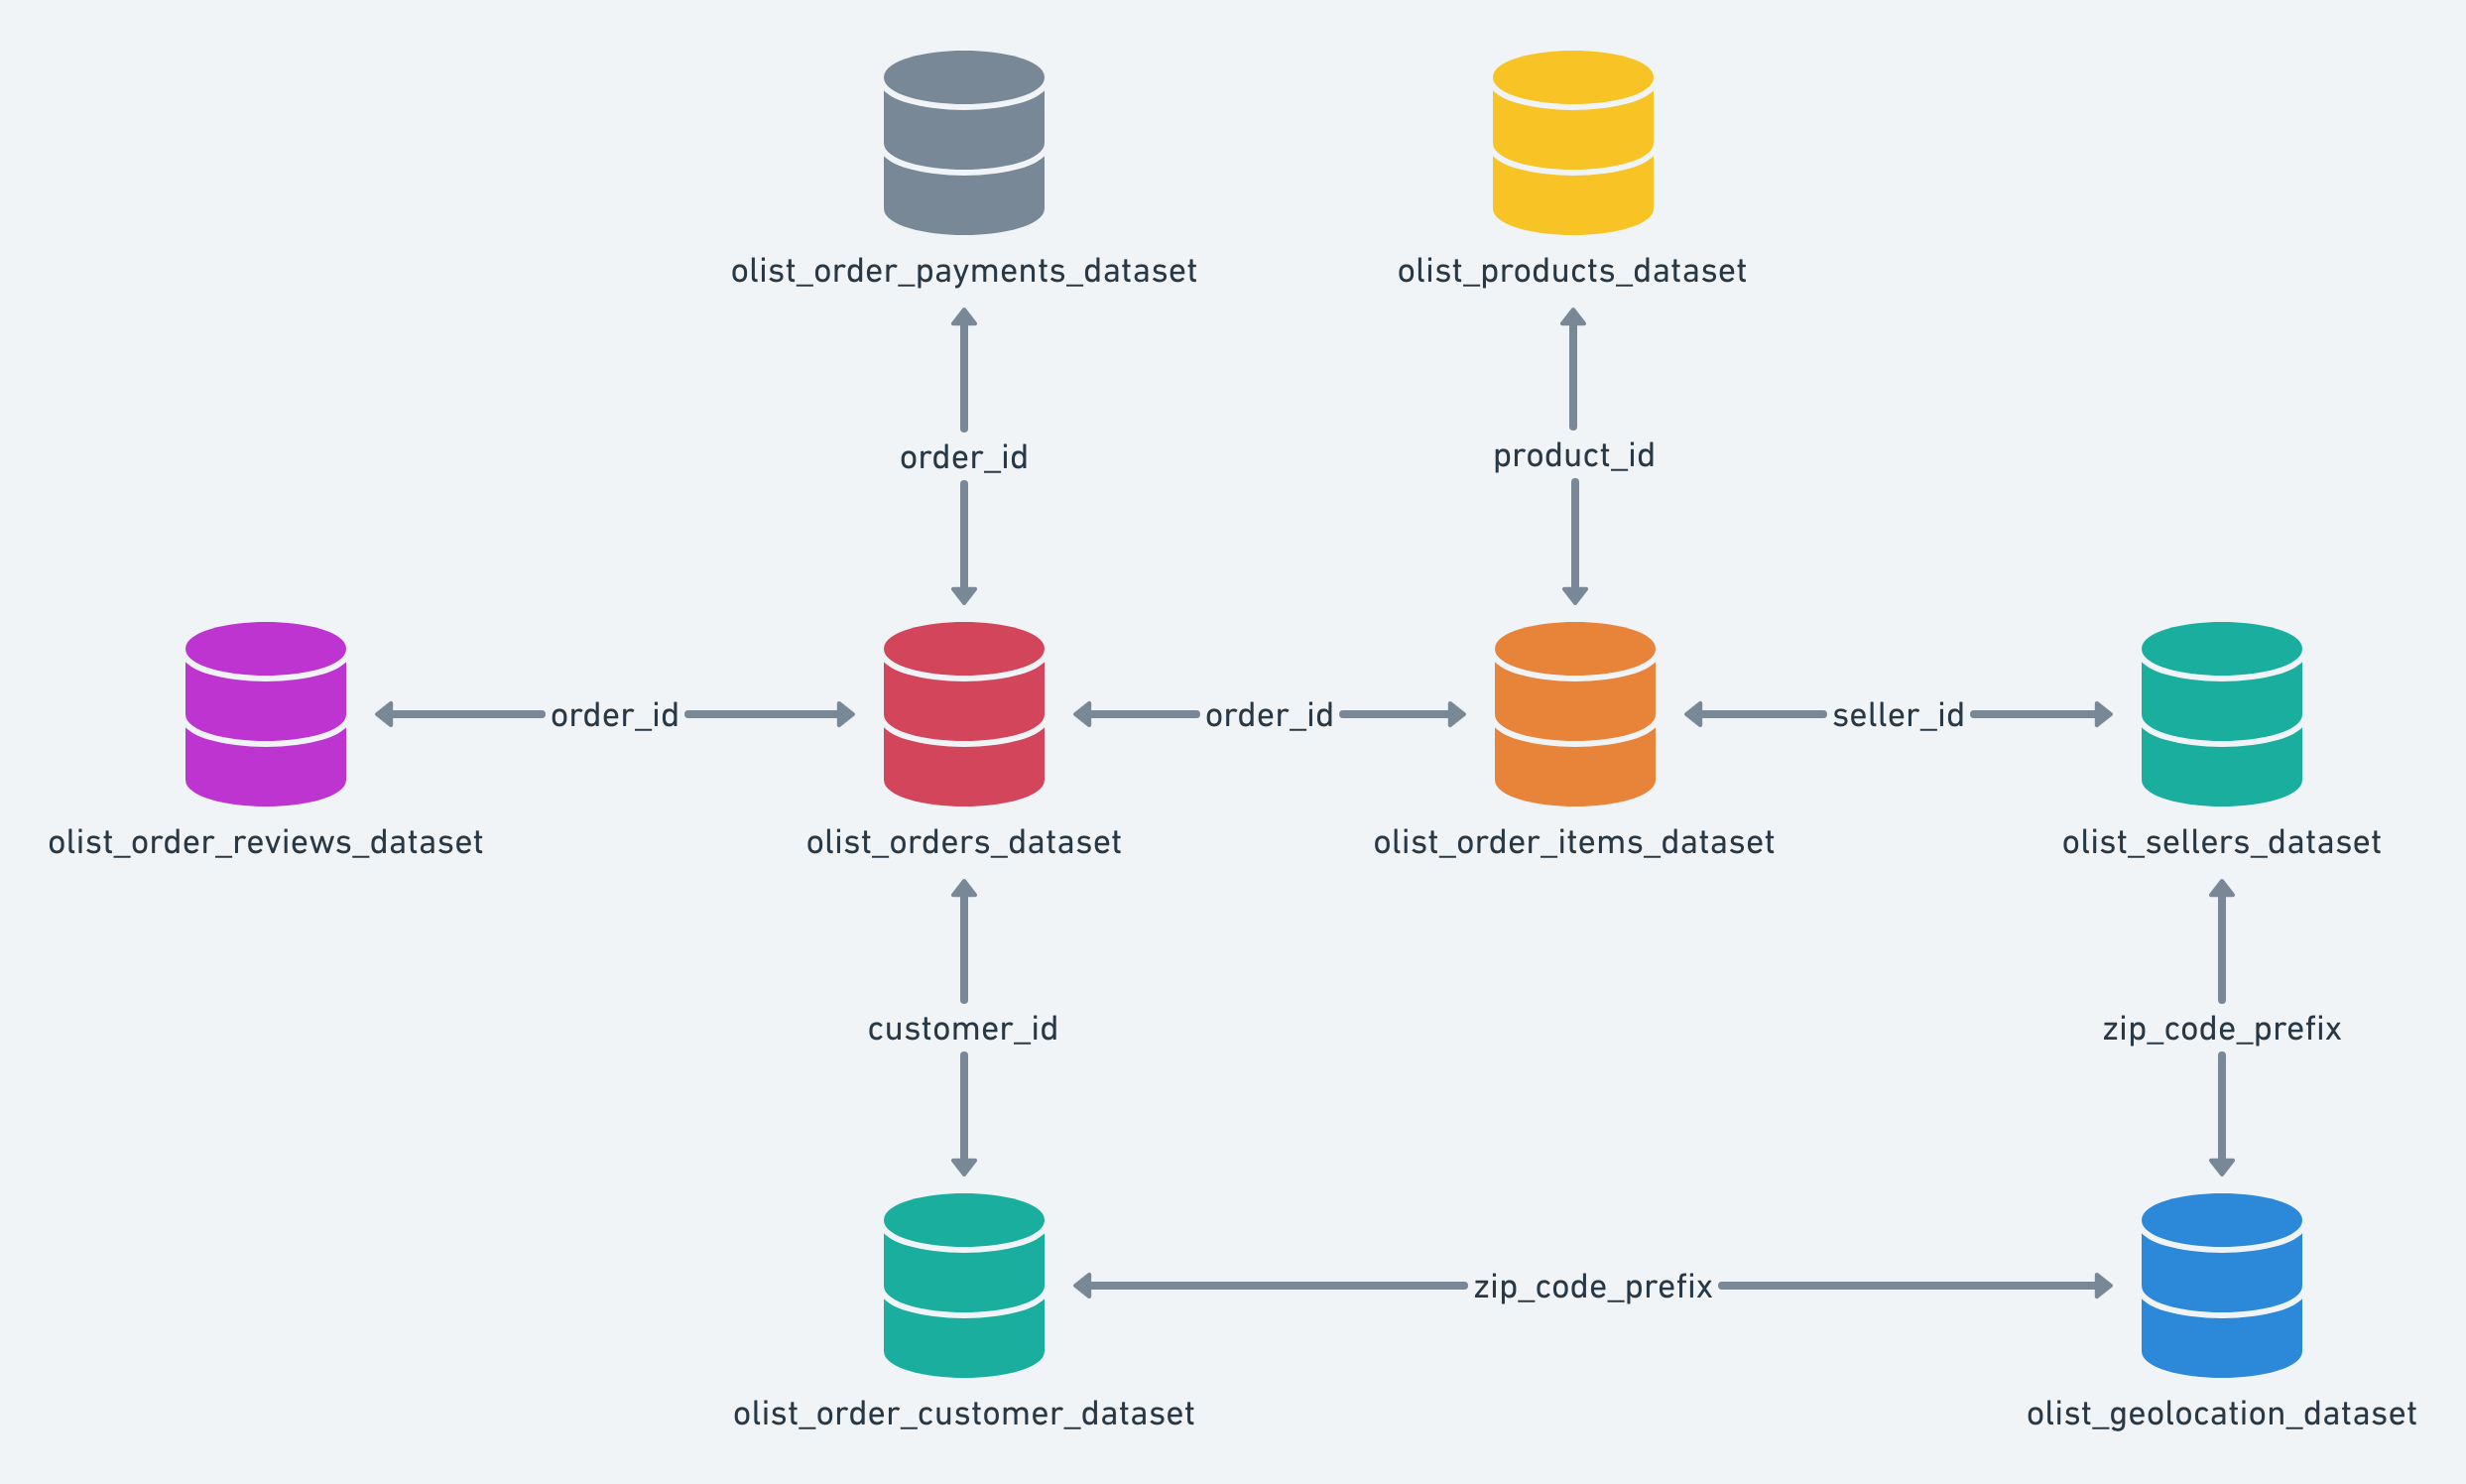

In [24]:
# Carregamento de todos datasets
dtCustomers = pd.read_csv('../data/olist_customers_dataset.csv', encoding = 'utf8')
dtGeolocation = pd.read_csv('../data/olist_geolocation_dataset.csv', encoding = 'utf8')
dtOrderItems = pd.read_csv('../data/olist_order_items_dataset.csv', encoding = 'utf8')
dtOrderPayments = pd.read_csv('../data/olist_order_payments_dataset.csv', encoding = 'utf8')
dtOrderReviews = pd.read_csv('../data/olist_order_reviews_dataset.csv', encoding = 'utf8')
dtOrders = pd.read_csv('../data/olist_orders_dataset.csv', encoding = 'utf8')
dtProducts = pd.read_csv('../data/olist_products_dataset.csv', encoding = 'utf8')
dtSellers = pd.read_csv('../data/olist_sellers_dataset.csv', encoding = 'utf8')

# Analise Exploratória

Como as vendas foram afetadas entre 2016 e 2018? Para isso iremos fazer um grafico de analise temporal ao longo dos pedidos aprovados.

In [25]:
# Dataset de pedidos
dtOrders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [35]:
dtOrders.dtypes

order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

In [52]:
# Colunas do tipo data
dateColumns = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',\
               'order_delivered_customer_date', 'order_estimated_delivery_date']

# Dataset de analise temporal
dtOrdersAjustado = dtOrders.copy()

In [53]:
# Convertendo columas de data para date
for col in dateColumns:
    dtOrdersAjustado[col] = pd.to_datetime(dtOrdersAjustado[col], format = '%Y-%m-%d %H:%M:%S')

In [54]:
dtOrdersAjustado.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [55]:
dtOrdersAjustado.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

In [59]:
# Verificando tipos unicos
print(dtOrdersAjustado.nunique())

order_id                         99441
customer_id                      99441
order_status                         8
order_purchase_timestamp         98875
order_approved_at                90733
order_delivered_carrier_date     81018
order_delivered_customer_date    95664
order_estimated_delivery_date      459
dtype: int64


In [61]:
# Verificando columas com null
print(dtOrdersAjustado.isna().sum())

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64


Verificamos que possuem valores NA no dataset. Abaixo iremos verificar que possuem apenas 2980 observações como NA. Por essas representaem um valor pequeno do dataset iremos removelas. 

In [71]:
# Verificando valores NA
dtOrdersAjustado[dtOrdersAjustado.isna().any(axis = 1)]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09
44,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaT,2018-06-28
103,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,2018-08-07 06:15:14,NaT,NaT,2018-08-21
128,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaT,NaT,2017-10-03
154,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,NaT,2018-02-07
...,...,...,...,...,...,...,...,...
99283,3a3cddda5a7c27851bd96c3313412840,0b0d6095c5555fe083844281f6b093bb,canceled,2018-08-31 16:13:44,NaT,NaT,NaT,2018-10-01
99313,e9e64a17afa9653aacf2616d94c005b8,b4cd0522e632e481f8eaf766a2646e86,processing,2018-01-05 23:07:24,2018-01-09 07:18:05,NaT,NaT,2018-02-06
99347,a89abace0dcc01eeb267a9660b5ac126,2f0524a7b1b3845a1a57fcf3910c4333,canceled,2018-09-06 18:45:47,NaT,NaT,NaT,2018-09-27
99348,a69ba794cc7deb415c3e15a0a3877e69,726f0894b5becdf952ea537d5266e543,unavailable,2017-08-23 16:28:04,2017-08-28 15:44:47,NaT,NaT,2017-09-15


In [76]:
# Dropando valores NA
dtOrdersAjustado = dtOrdersAjustado.dropna()

In [80]:
# Verificando se possuem valores duplicados
print(sum(dtOrdersAjustado.duplicated()))

0


In [83]:
dtOrdersAjustado.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


C:\Users\herik\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:337: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


KeyboardInterrupt: 

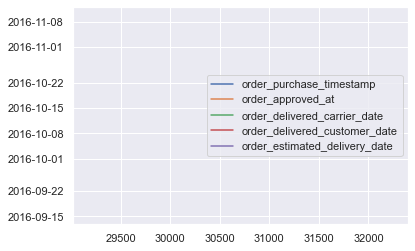

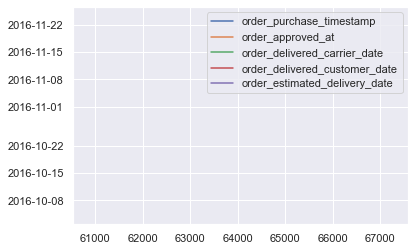

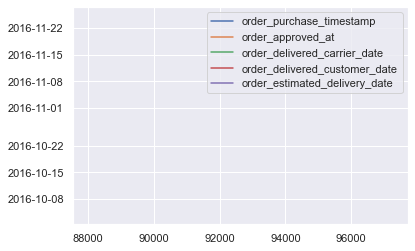

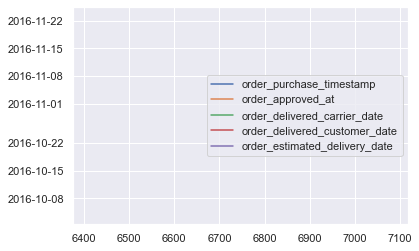

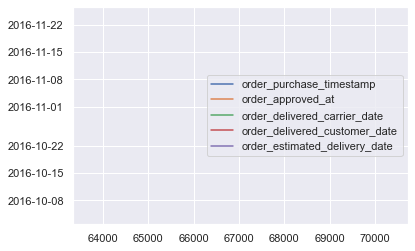

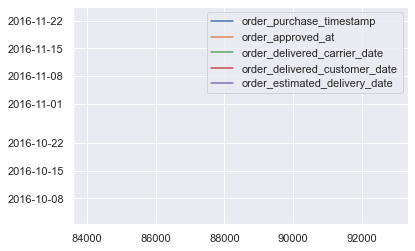

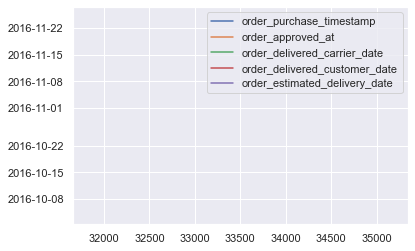

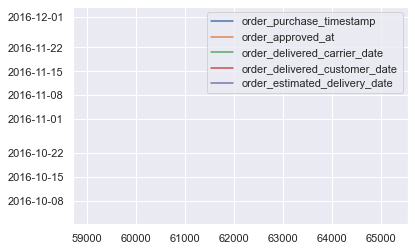

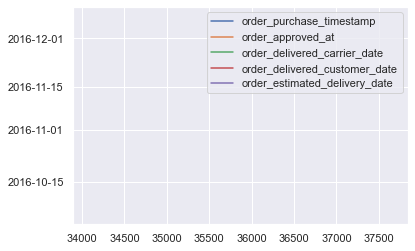

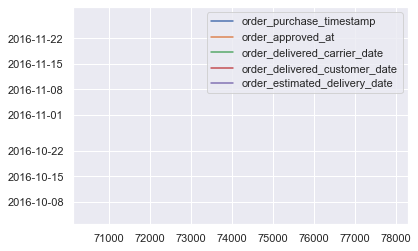

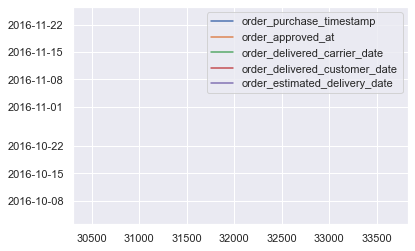

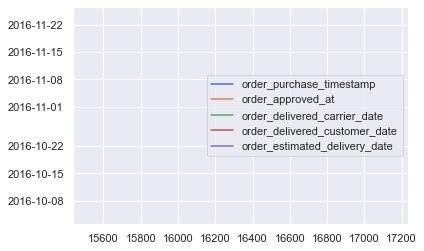

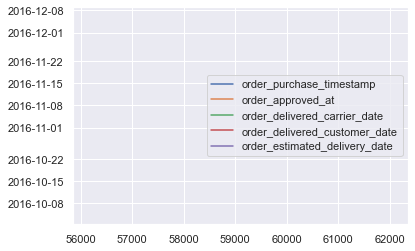

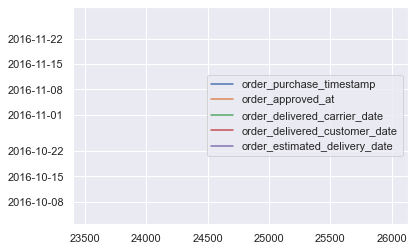

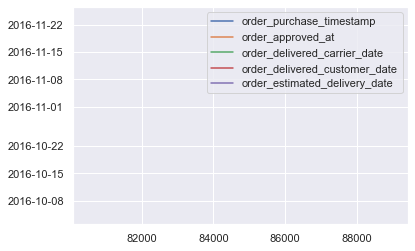

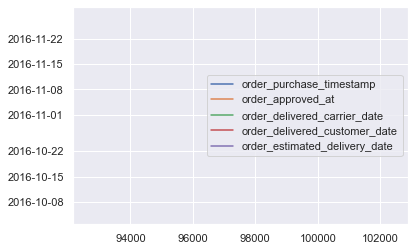

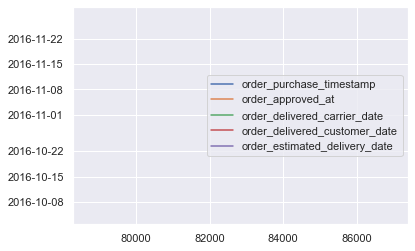

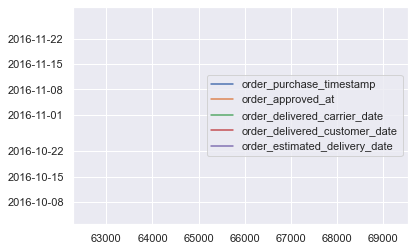

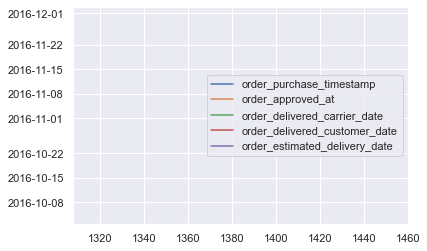

Error in callback <function flush_figures at 0x00000296D3A0B160> (for post_execute):


KeyboardInterrupt: 

In [86]:
dtOrdersAjustado.groupby('order_approved_at').plot(kind = 'line')

<AxesSubplot:xlabel='order_approved_at'>

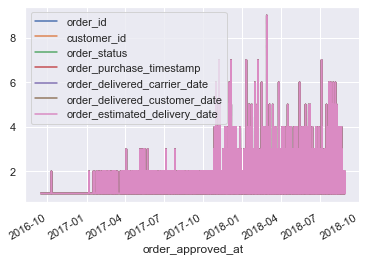

In [89]:
dtOrdersAjustado.groupby('order_approved_at').count().plot(kind = 'line')

# Pré Processamento

# O resto é história